In [92]:
import matplotlib.pyplot as plt
import gzip
from Recessive import *
import numpy as np

In [7]:
Annotation = "/home/local/users/jw/Genetics_Projects/SPARK/30K/VCF/TrioVCF/sites/SPARK30K.TrioSamples.Chr1.vep.vcf.gz"
EUR = "/home/local/users/jw/Genetics_Projects/SPARK/spark_genomics/dat/SPARK30K.TrioSamples.Chr1.eurAF.vcf.gz"

In [10]:
def getINFO(info_string):
    infolist = info_string.split(';')
    infodict = {}
    for kv in infolist:
        kv = kv.split('=')
        if len(kv) == 2:
            k, v = kv
            infodict[k] = v
    return infodict

def Load_VEP(VCF):
    fin = gzip.open(VCF, 'rt')
    res = {}
    for l in fin:
        if l.startswith("##INFO=<ID=CSQ"):
            CSQ_terms = l.strip().split("Format: ")[1].split("|")
        elif l.startswith("#"):
            continue
        else:
            llist = l.strip().split("\t")
            key = "-".join([llist[0], llist[1], llist[3], llist[4]])
            infodict = getINFO(llist[7])
            VEPs = infodict["CSQ"].split(",")
            VEPs = [dict(zip(CSQ_terms, vep.split("|"))) for vep in VEPs]
            res[key] = VEPs
    return res

In [11]:
VEP = Load_VEP(Annotation)

In [12]:
AF_gnomADg, AF_spark = [], []
GF_gnomADg, GF_spark = [], []
consequces = {}
consequces2 = {}
fin = gzip.open(EUR, 'rt')
for l in fin:
    if l.startswith("#"):
        continue
    else:
        llist = l.strip().split("\t")
        key = "-".join([llist[0], llist[1], llist[3], llist[4]])
        veps = VEP[key]
        infodict = getINFO(llist[7])
        for i, allele in enumerate(llist[4].split(",")):
            AF = float(infodict["EUR_AF"].split(",")[i])
            if AF == 0:
                continue
            GF_hom = float(infodict["EUR_AC_Hom"].split(",")[i])
            AN = float(infodict["EUR_AN"])/2
            for vep in veps:
                if vep["Allele"] == allele or (vep["Allele"]=="-" and len(allele) < len(llist[3])):
                    vep["gnomADg_AF_NFE"] = vep["gnomADg_AF_NFE"].split("&")[0]
                    gnomADg_af = 0 if (vep["gnomADg_AF_NFE"] == "" or vep["gnomADg_AF_NFE"] == ".")\
                    else float(vep["gnomADg_AF_NFE"])
                    gnomADg_hom = 0 if vep["gnomADg_Hom_NFE"]=="" else float(vep["gnomADg_Hom_NFE"])
                    AF_gnomADg.append(gnomADg_af)
                    GF_gnomADg.append(gnomADg_hom/15708)
                    AF_spark.append(AF)
                    GF_spark.append(GF_hom/AN)
                    if vep["Consequence"] not in consequces2:
                        consequces2[vep["Consequence"]] = 1
                    else:
                        consequces2[vep["Consequence"]] += 1
                    cons = vep["Consequence"].split("&")
                    for con in cons:
                        if con not in consequces:
                            consequces[con] = 1
                        else:
                            consequces[con] += 1
                        break

In [13]:
print (consequces)
print ()
print (consequces2)

{'5_prime_UTR_variant': 33964, 'synonymous_variant': 140423, 'downstream_gene_variant': 453799, 'missense_variant': 255531, 'frameshift_variant': 5119, 'stop_gained': 6960, 'upstream_gene_variant': 359274, 'intron_variant': 947044, 'splice_region_variant': 47203, 'non_coding_transcript_exon_variant': 152503, '3_prime_UTR_variant': 77852, 'inframe_deletion': 3105, 'splice_acceptor_variant': 2607, 'splice_donor_variant': 3480, 'stop_lost': 268, 'inframe_insertion': 166, 'start_lost': 682, 'mature_miRNA_variant': 75, 'stop_retained_variant': 144, 'incomplete_terminal_codon_variant': 39, 'coding_sequence_variant': 50, 'intergenic_variant': 297, 'protein_altering_variant': 3}

{'5_prime_UTR_variant': 30990, 'synonymous_variant': 132899, 'downstream_gene_variant': 453799, 'missense_variant': 233906, 'frameshift_variant': 4659, 'stop_gained': 6202, 'upstream_gene_variant': 359274, 'intron_variant': 616602, 'splice_region_variant&intron_variant': 25431, 'missense_variant&splice_region_variant'

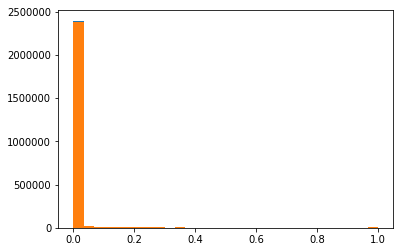

In [14]:
plt.hist(AF_gnomADg, bins=30)
plt.hist(AF_spark, bins=30)
plt.show()

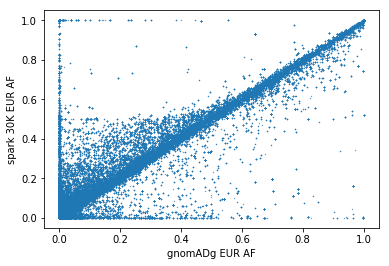

In [90]:
plt.scatter(AF_gnomADg, AF_spark, s=0.1)
plt.xlabel("gnomADg EUR AF")
plt.ylabel("spark 30K EUR AF")
plt.show()

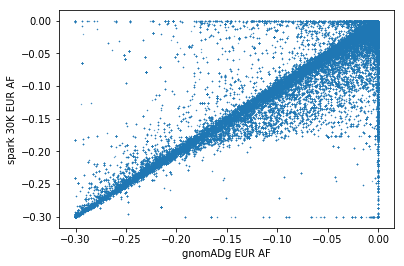

In [93]:
X = [-np.log10(x+1) for x in AF_gnomADg]
Y = [-np.log10(x+1) for x in AF_spark]
plt.scatter(X, Y, s=0.1)
plt.xlabel("gnomADg EUR AF")
plt.ylabel("spark 30K EUR AF")
plt.show()

In [16]:
import csv

In [17]:
# Get Autozygous Region
fin = open("../dat/roh.txt")
fout = open("../dat/roh.az.txt", 'w')
for l in fin:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    if llist[4] == "1":
        fout.write(l)

In [18]:
genecodechr21 = "/home/local/users/jw/vep_data/homo_sapiens/GeneCodeV29/CHRs/genecodev29.21.gtf"

class GTFRecord:
    def __init__(self, Chr, source, Type, start, end, strand, info):
        self.Chr = Chr
        self.source = source
        self.Type = Type
        self.start = start
        self.end = end
        self.strand = strand
        self.info = info

def gtf_info_parser(info):
    res = {}
    for term in info.split(";"):
        if term == "":
            continue
        #print(">",term)
        key,v = term.split()
        v = v.strip('"')
        res[key]=v
    return res
        
def LoadGeneCode(genecodefil):
    Genes = {}
    Transcripts = {}
    hand = open(genecodefil, 'rt')
    for l in hand:
        if l.startswith("#"):
            continue
        llist = l.strip().split("\t")
        info = gtf_info_parser(llist[8])
        if llist[2] == "gene":
            Genes[info["gene_name"]] = GTFRecord(llist[0], llist[1], llist[2], llist[3], llist[4], llist[6], info)
            Transcripts[info["gene_name"]] = []
        elif llist[2] == "transcript":
            Transcripts[info["gene_name"]].append(GTFRecord(llist[0], llist[1], llist[2], llist[3], llist[4], llist[6], info))
    return Genes, Transcripts 

In [19]:
Genes, Transtripts = LoadGeneCode(genecodechr21)

In [20]:
import pysam
import csv
import numpy
import matplotlib as plt

In [21]:
GenotypeFil = pysam.TabixFile("/home/local/users/jw/Genetics_Projects/SPARK/30K/VCF/TrioVCF/Genotypes/SPARK30K.TrioSamples.Chr21.vcf.gz")
VEPFil = pysam.TabixFile("/home/local/users/jw/Genetics_Projects/SPARK/30K/VCF/TrioVCF/sites/SPARK30K.TrioSamples.Chr21.vep.vcf.gz")
CohortAFFil = pysam.TabixFile("/home/local/users/jw/Genetics_Projects/SPARK/spark_genomics/dat/SPARK30K.TrioSamples.Chr21.eurAF.vcf.gz")

In [22]:
CSQ_header = [X.strip().split("Format: ")[1].rstrip('>\"').split("|") for X in VEPFil.header if X.startswith("##INFO=<ID=CSQ")][0]
print(CSQ_header)

['Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Gene', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'HGVSc', 'HGVSp', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'DISTANCE', 'STRAND', 'FLAGS', 'SYMBOL_SOURCE', 'HGNC_ID', 'CANONICAL', 'SOURCE', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomAD_AF', 'gnomAD_AFR_AF', 'gnomAD_AMR_AF', 'gnomAD_ASJ_AF', 'gnomAD_EAS_AF', 'gnomAD_FIN_AF', 'gnomAD_NFE_AF', 'gnomAD_OTH_AF', 'gnomAD_SAS_AF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'ExAC_AF', 'ExAC_AF_AFR', 'ExAC_AF_AMR', 'ExAC_AF_Adj', 'ExAC_AF_EAS', 'ExAC_AF_FIN', 'ExAC_AF_NFE', 'ExAC_AF_OTH', 'ExAC_AF_SAS', 'MPC', 'REVEL', 'CADD_PHRED', 'CADD_RAW', 'gnomADg', 'gnomADg_AF_AFR', 'gnomADg_AF_AMR', 'gnomADg_AF_ASJ', 'gnomADg_AF_EAS', 'gnomADg_AF_FIN', 'gnomADg_AF_NFE', 'gnomADg_AF_OTH', 'gnomADg_Hom_AFR', 'gnomADg_Hom_AMR', 'gnomADg_Hom_ASJ', 'gnomADg_Hom_EAS', 'gnomADg_Hom_NFE', 'gnomADg_Hom_OTH', 'gnomADg_Hom_SAS', 'gnomADe', 'gnom

In [23]:
Samples = GenotypeFil.header[-1].split("\t")[9:]
print(Samples[:10])

['SP0030253', 'SP0000006', 'SP0030255', 'SP0013567', 'SP0000009', 'SP0013501', 'SP0024927', 'SP0000014', 'SP0024909', 'SP0024943']


In [24]:
PedFil = "/home/local/users/jw/Genetics_Projects/SPARK/spark_genomics/dat/EUR_Trios.ped"
Trios = []
reader = csv.reader(open(PedFil, 'rt'), delimiter="\t")
counter = 0
for row in reader:
    counter += 1
    if counter == 1:
        NewTrio = []
        row.append(Samples.index(row[1]))
        NewTrio.append(row)
    if counter == 2:
        row.append(Samples.index(row[1]))
        NewTrio.append(row)
    if counter == 3:
        row.append(Samples.index(row[1]))
        NewTrio.append(row)
        Trios.append(NewTrio)
        counter = 0

In [25]:
print (Trios[0])

[['SF0013567', 'SP0013567', 'SP0000009', 'SP0013501', '1', '2', 3], ['SF0013567', 'SP0000009', '0', '0', '1', '1', 4], ['SF0013567', 'SP0013501', '0', '0', '2', '1', 5]]


In [26]:
N = 5
for i, (Gene,GTF) in enumerate(Genes.items()):
    start, end = int(GTF.start), int(GTF.end)
    print(Gene, start, end)
    veps = []
    for term in VEPFil.fetch('21', start, end):
        print(term)
    if i >= N:
        break

FP565260.4 5011799 5017145
FP565260.3 5022493 5040666
GATD3B 5079294 5128425
FP565260.2 5116343 5133805
FP565260.1 5130871 5154734
FP565260.6 5155499 5165472


In [70]:
def match_allele_csq(Ref, Alts, csq_head, csq_string):
    # Trim Leading Base
    Alts = Alts.split(",")
    if len(list(set([x[0] for x in Alts])))==1 and Ref[0] == list(set([x[0] for x in Alts]))[0]:
        _Ref = Ref[1:] if len(Ref[1:]) >0 else "-"
        _Alts = [Alt[1:] if len(Alt[1:]) >0 else "-" for Alt in Alts]
        #print (Ref, Alts, ";", _Ref, _Alts)
    else:
        _Alts = Alts
    res = {}
    csqs = csq_string.split(",")
    csqs = [dict(zip(csq_head, vep.split("|"))) for vep in csqs]
    for i, Alt in enumerate(Alts):
        res[Alt] = []
        for j, csq in enumerate(csqs):
            if csq["Allele"] == _Alts[i]:
                csq["Consequence"] = csq["Consequence"] .split("&")
                res[Alt].append(csq)
    return res

In [75]:
LGD = set(["splice_acceptor_variant", "splice_donor_variant", "stop_gained", 
       "stop_lost", "start_lost", "frameshift_variant"])

In [ ]:
def LookUpBiallic(r, Vartype, var, gts, trios):
    nhaps = 0 # hap with class C
    Nhaps = 0 # total N of haps at this site
    for i, (prob, fa, mo) in enumerate(trios):
        gt_prob, gt_fa, gt_mo = r.GenotypeQC(gts[prob[6]]), r.GenotypeQC(gts[fa[6]]), r.GenotypeQC(gts[mo[6]])
        if gt_prob == False or gt_fa == False or gt_mo == False:
            continue # gt failed QC
        elif (gt_prob[0] not in gt_fa and gt[1] not in gt_mo) or (gt_prob[1] not in gt_fa and gt[0] not in gt_mo):
            continue # mendelian error
        else:
            if gt_fa[0] != 0:
                haps += 1
            if gt_fa[1] != 0:
                haps += 1
            if gt_mo[0] != 0:
                haps += 1
            if gt_mo[1] !+ 0:
                haps += 1
            if gt_prob[1] == gt_fa[1]: #paternal var
                trios.AC1 = True
            if gt_prob[1] == gt_mo[1]: #maternal var
                trios.AC2 = True
                
            

In [87]:
gene = "TPTE"
syn_Biallics = [(None, None)] * len(Trios)
lgd_Biallics = [(None, None)] * len(Trios)
dmis_Biallics = [(None, None)] * len(Trios)
GTF = Genes[gene]
start, end = int(GTF.start), int(GTF.end)
print(Gene, start, end)
veps, cohort, genotypes = [],[], []
for term in VEPFil.fetch('21', start, end):
    veps.append(term)
for term in CohortAFFil.fetch('21', start, end):
    cohort.append(term)
for term in GenotypeFil.fetch('21', start, end):
    genotypes.append(term)
print(len(veps),len(cohort),len(genotypes))

for var in zip(veps, cohort, genotypes):
    llist = var[0].split("\t")
    Chr, Pos, Ref, Alts = llist[0], llist[1], llist[3], llist[4]
    cohort_af = list(map(float, getINFO(var[1].split("\t")[7])["EUR_AF"].split(",")))
    Sample_genotypes = genotypes[9:]
    infodict = getINFO(llist[7])
    Allele_CSQ_dict = match_allele_csq(Ref, Alts, CSQ_header, infodict["CSQ"])
    for i, Alt in enumerate(Alts.split(",")):
        #print(Alt, Allele_CSQ_dict[Alt][0])
        try:
            Allele_CSQ_dict[Alt][0]["gnomADg_AF_NFE"] = Allele_CSQ_dict[Alt][0]["gnomADg_AF_NFE"].split("&")[0]
            gnomADg_af = 0 if (vep["gnomADg_AF_NFE"] == "" or vep["gnomADg_AF_NFE"] == ".")\
                    else float(vep["gnomADg_AF_NFE"])
            Allele_CSQ_dict[Alt][0]["gnomADe_AF_NFE"] = Allele_CSQ_dict[Alt][0]["gnomADe_AF_NFE"].split("&")[0]
            gnomADe_af = 0 if (vep["gnomADe_AF_NFE"] == "" or vep["gnomADe_AF_NFE"] == ".")\
                    else float(vep["gnomADe_AF_NFE"])
            af = cohort_af[i]
            if gnomADg_af > 1e-2 or af > 1e-2 or af == 0:
                continue
            cons = Allele_CSQ_dict[Alt][0]["Consequence"]
            #print (cons)
            if len(set(cons).intersection(LGD))>= 1:
                print (gnomADe_af, af, cons)
            elif "synonymous_variant" in set(cons):
                print (gnomADe_af, af, cons)
            elif "missense_variant" in set(cons) and float(Allele_CSQ_dict[Alt][0]["CADD_PHRED"]) > 25:
                print (gnomADe_af, af, cons, float(Allele_CSQ_dict[Alt][0]["CADD_PHRED"]))
        except KeyError:
            print("KeyError", Alt, Allele_CSQ_dict)
        except IndexError:
            print("IndexError", Ref, Alts, llist[7], Allele_CSQ_dict)
        break
        for Trio in Trios:
            proband, Father, Mother = Trio
            gt_p, gt_f, ft_m = Sample_genotypes[proband[6]], \
            Sample_genotypes[Father[6]], Sample_genotypes[Mother[6]]
            # Check AC1:
            
            # Check AC2:

FP565260.6 10521553 10606140
995 995 995
0 6.383250351078769e-05 ['splice_acceptor_variant']
0 6.853070175438596e-05 ['synonymous_variant']
0 6.903216899074968e-05 ['synonymous_variant']
0 6.922331441229406e-05 ['synonymous_variant']
0 0.00025233409033560434 ['synonymous_variant']
0 6.527415143603133e-05 ['synonymous_variant']
0 6.407791874919902e-05 ['splice_acceptor_variant']
0 0.00012515644555694618 ['synonymous_variant']
0 6.397134083930399e-05 ['missense_variant'] 25.7
0 0.0006322711178553364 ['synonymous_variant']
0 0.0002559836170485089 ['frameshift_variant']
0 0.00019392372333548803 ['synonymous_variant']
0 6.485925541574782e-05 ['synonymous_variant']
0 0.002051473330846699 ['stop_gained']
0 6.215040397762585e-05 ['missense_variant'] 25.2
0 0.005904288377874456 ['synonymous_variant']
0 6.215040397762585e-05 ['missense_variant'] 25.1
0 0.0007458048477315103 ['synonymous_variant']
0 6.215040397762585e-05 ['splice_donor_variant']
0 6.329113924050633e-05 ['synonymous_variant']
0 6.